In [1]:
import pyspark
import os
import sys
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import time

spark = (
    SparkSession.builder.appName("Sentiment Analysis with Vader") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "6") \
    .config("spark.executor.instances", "3") \
    #.config("spark.sql.shuffle.partitions", "64") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.broadcast.compress", "true") \
    .master("spark://master:7077") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://master:9000")
    .getOrCreate()
)

schema = StructType([
    StructField('marketplace', StringType(), True),
    StructField('customer_id', StringType(), True),
    StructField('review_id', StringType(), True),
    StructField('product_id', StringType(), True),
    StructField('product_parent', StringType(), True),
    StructField('product_title', StringType(), True),
    StructField('product_category', StringType(), True),
    StructField('star_rating', StringType(), True),
    StructField('helpful_votes', StringType(), True),
    StructField('total_votes', StringType(), True),
    StructField('vine', StringType(), True),
    StructField('verified_purchase', StringType(), True),
    StructField('review_headline', StringType(), True),
    StructField('review_body', StringType(), True),
    StructField('review_date', StringType(), True)
])

hdfs_path_small = 'hdfs://master:9000/user/ubuntu/datasets/amazon-us-customer-reviews-dataset/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'
hdfs_path_complete = 'hdfs://master:9000/user/ubuntu/datasets/amazon-us-customer-reviews-dataset/*.tsv'

df = spark.read.csv(hdfs_path_small, sep='\t', header=True, schema=schema)
df = df.repartition(36)

df.printSchema()
print(f"Total rows: {df.count()}")


# ----- Split 2 -----


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.storagelevel import StorageLevel
import time
from datetime import datetime

#!hdfs dfs -rm -r datasets/outputs/
!hdfs dfs -mkdir datasets/outputs/
!rm -rf ./outputs/

df_reviews = df.select('review_id', 'review_body').filter(F.col('review_body').isNotNull())

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    magnitude = compound_score
    
    return sentiment, magnitude

@F.udf(returnType=StructType([
    StructField("sentiment", StringType(), True),
    StructField("magnitude", FloatType(), True)
]))
def analyze_sentiment_udf(text):
    sentiment, magnitude = analyze_sentiment(text)
    return {"sentiment": sentiment, "magnitude": magnitude}

def remove_commas_from_review(review_text):
    if review_text:
        return review_text.replace(",", " ")
    return review_text

def save_to_csv(dataframe):
    time_start = time.time()
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_path = f"hdfs://master:9000/user/ubuntu/datasets/outputs/amazon_sentiment_results_{timestamp}"
    print(f"Csv will be saved to: {output_path}")
    
    dataframe.select("review_id", "review_body_cleaned", "sentiment", "magnitude").coalesce(1).write.option("header", "true").option("quote", "\"").mode("overwrite").csv(output_path)
    
    time_end = time.time()
    print(f"Time taken writing the csv: {time_end - time_start} seconds | Saved to: {output_path}")
    
    !mkdir ./outputs
    !hdfs dfs -get datasets/outputs/amazon_sentiment_results_{timestamp}/ ./outputs/


remove_commas_udf = F.udf(remove_commas_from_review, StringType())
time_start = time.time()

df_with_sentiment = df_reviews.withColumn("sentiment_data", analyze_sentiment_udf(F.col('review_body')))
df_with_sentiment = df_with_sentiment \
    .withColumn("sentiment", F.col("sentiment_data.sentiment").cast(StringType())) \
    .withColumn("magnitude", F.col("sentiment_data.magnitude").cast(FloatType())) \
    .drop("sentiment_data")
df_with_sentiment = df_with_sentiment.withColumn("review_body_cleaned", remove_commas_udf(F.col('review_body')))

time_end = time.time()
print(f"Time processing sentiment: {time_end - time_start} seconds")

df_with_sentiment.select('review_id', 'review_body_cleaned', 'sentiment', 'magnitude').show(50, truncate=25)
time_end_aux = time.time()
print(f"Time printing subset: {time_end_aux - time_end} seconds")

#save_to_csv(df_with_sentiment);
# ATTENTION: (For now) Do not try to save the complete dataset as a csv it will go infinitly


# ----- Split 3 -----


time_start = time.time()
df_dataset = df.join(
    df_with_sentiment.select("review_id", "sentiment", "magnitude"),
    on="review_id",
    how="left"
)
time_end = time.time()
print(f"Time merging the dataframes: {time_end - time_start} seconds")

df_dataset.show(50, truncate=25)
time_end_aux = time.time()
print(f"Time printing subset: {time_end_aux - time_end} seconds")
# ATTENTION: The print is fine, you just need to zoom out

df_dataset = df_dataset.withColumn("review_year_month", F.date_format(F.col("review_date"), "yyyy-MM"))
time_end = time.time()
print(f"Time generating graph subset: {time_end - time_end_aux} seconds")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/06 11:37:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



[Stage 0:>                                                          (0 + 6) / 6]

Total rows: 104975


mkdir: `datasets/outputs': File exists
Time processing sentiment: 0.20618033409118652 seconds


+--------------+-------------------------+---------+---------+
|     review_id|      review_body_cleaned|sentiment|magnitude|
+--------------+-------------------------+---------+---------+
|R2QNF0SF0BLZRK|why can not automatic ...| positive|   0.3818|
| RQ13LUPZ26MPY|I am sorry I really ha...| positive|   0.2617|
|R3NCOZJ0HH6401|          Good  thank you| positive|   0.6597|
|R2T76C9JGJ3NJU|The best charging cabl...| positive|   0.4588|
|R36YMVE2J0D89Y|I bough one in Novembe...|  neutral|      0.0|
| RH5S9U2O986EO|No complaints. So far ...| positive|   0.6319|
|R1ETUR96E0AWM6|Cheaper than buying a ...| negative|  -0.7351|
|R3756YUWLIPIKV|Regular crash  when th...| negative|  -0.4574|
| RFVSX4ZY52PJK|Do not buy this  it's ...| positive|   0.3182|
|R3KU91065W0MEB|     as advertised thanks| positive|   0.4404|
| RX98CPFPLNO3W|This portable cassette...|  neutral|      0.0|
|R2C57357K55UVG|I bought this a while ...| positive|    0.875|
| RAZX9ZCFPGCKO|  Love love love loved it| positive|   

[Stage 12:======================================================> (35 + 1) / 36]

+--------------+-----------+-----------+----------+--------------+-------------------------+------------------+-----------+-------------+-----------+----+-----------------+-------------------------+-------------------------+-----------+---------+---------+
|     review_id|marketplace|customer_id|product_id|product_parent|            product_title|  product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|          review_headline|              review_body|review_date|sentiment|magnitude|
+--------------+-----------+-----------+----------+--------------+-------------------------+------------------+-----------+-------------+-----------+----+-----------------+-------------------------+-------------------------+-----------+---------+---------+
|R10S1XCOUZULWK|         US|   48094448|B004Y3D8OE|     654290797|PAC C2R-VW2 RADIO REPL...|Mobile_Electronics|          4|            0|          0|   N|                Y|But it is just as good...|It does what it claims...| 2014

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 35082)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates


Here's a graph of the most and best rated products of each month:
TOOLTIP: Left click any dot to view info on the product


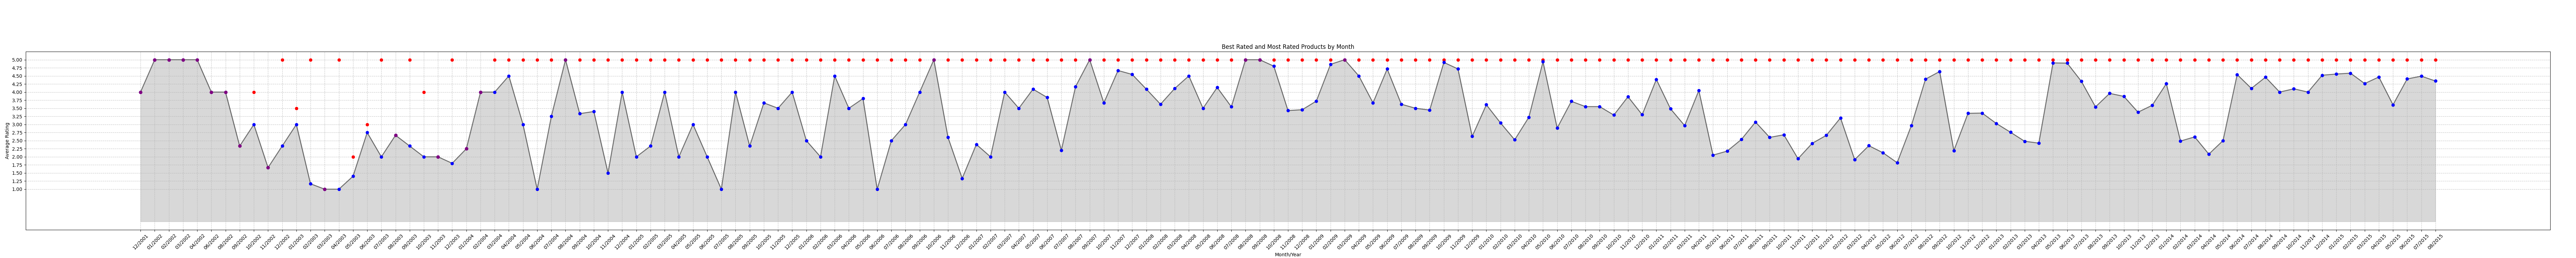

In [2]:
%matplotlib widget
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Here's a graph of the most and best rated products of each month:\nTOOLTIP: Left click any dot to view info on the product")

df_product_monthly = df_dataset.groupBy("product_id", "review_year_month") \
    .agg(
        F.avg("star_rating").alias("avg_rating"),
        F.count("review_id").alias("review_count"),
        F.first("product_title").alias("product_title")
    )

window_best_rated = Window.partitionBy("review_year_month").orderBy(F.desc("avg_rating"))
df_best_rated = df_product_monthly.withColumn("rank", F.row_number().over(window_best_rated)).filter(F.col("rank") == 1)

window_most_rated = Window.partitionBy("review_year_month").orderBy(F.desc("review_count"))
df_most_rated = df_product_monthly.withColumn("rank", F.row_number().over(window_most_rated)).filter(F.col("rank") == 1)

best_rated_data = df_best_rated.select("review_year_month", "product_id", "product_title", "review_count", "avg_rating").collect()
most_rated_data = df_most_rated.select("review_year_month", "product_id", "product_title", "review_count", "avg_rating").collect()

best_rated_data = [row for row in best_rated_data if row["avg_rating"] is not None and row["review_year_month"] is not None]
most_rated_data = [row for row in most_rated_data if row["avg_rating"] is not None and row["review_year_month"] is not None]

best_rated_x = []
best_rated_y = []
best_rated_tooltips = []
for row in best_rated_data:
    best_rated_x.append(row["review_year_month"])
    best_rated_y.append(row["avg_rating"])
    best_rated_tooltips.append(f"Product ID: {row['product_id']}\nTitle: {row['product_title']}\nReviews: {row['review_count']}\nAvg Rating: {row['avg_rating']}")

most_rated_x = []
most_rated_y = []
most_rated_tooltips = []
for row in most_rated_data:
    most_rated_x.append(row["review_year_month"])
    most_rated_y.append(row["avg_rating"])
    most_rated_tooltips.append(f"Product ID: {row['product_id']}\nTitle: {row['product_title']}\nReviews: {row['review_count']}\nAvg Rating: {row['avg_rating']}")

best_rated_x = pd.to_datetime(best_rated_x, errors='coerce')
most_rated_x = pd.to_datetime(most_rated_x, errors='coerce')
best_rated_x = best_rated_x.dropna()
most_rated_x = most_rated_x.dropna()
best_rated_x = best_rated_x.strftime('%m/%Y')
most_rated_x = most_rated_x.strftime('%m/%Y')

fig, ax = plt.subplots(figsize=(75, 7.5))
plt.subplots_adjust(left=0.01, right=0.99, top=0.80)

best_rated_scatter = ax.scatter(best_rated_x, best_rated_y, color='red', label='Best Rated', zorder=3)
most_rated_scatter = ax.scatter(most_rated_x, most_rated_y, color='blue', label='Most Rated', zorder=3)

combined_x = []
combined_y = []
combined_tooltips = []
for x, y, tooltip in zip(most_rated_x, most_rated_y, most_rated_tooltips):
    if (x, y) in zip(best_rated_x, best_rated_y):
        best_index = list(best_rated_x).index(x)
        combined_x.append(x)
        combined_y.append(y)
        combined_tooltips.append((best_rated_tooltips[best_index], tooltip))

combined_scatter = ax.scatter(combined_x, combined_y, color='purple', label='Overlapping', zorder=3)


most_rated_x_sorted = np.array(most_rated_x)
most_rated_y_sorted = np.array(most_rated_y)

most_rated_df = pd.DataFrame({
    'x': most_rated_x_sorted,
    'y': most_rated_y_sorted
})

most_rated_df['x'] = pd.to_datetime(most_rated_df['x'], format='%m/%Y')
most_rated_df = most_rated_df.sort_values(by='x')

ax.plot(most_rated_df['x'].dt.strftime('%m/%Y'), most_rated_df['y'], color='black', linestyle='-', linewidth=2, zorder=2, alpha=0.5)
ax.fill_between(most_rated_df['x'].dt.strftime('%m/%Y'), most_rated_df['y'], color='gray', alpha=0.3, zorder=1)

ax.set_yticks(np.arange(1, 5.25, 0.25))
ax.set_xticks(sorted(set(best_rated_x.tolist() + most_rated_x.tolist())))
ax.set_xticklabels(sorted(set(best_rated_x.tolist() + most_rated_x.tolist())), rotation=45)
ax.set_xlabel('Month/Year')
ax.set_ylabel('Average Rating')
ax.set_title('Best Rated and Most Rated Products by Month')
ax.grid(True, linestyle='--', alpha=0.75)
ax.legend().set_visible(False)

current_annotation = None

def on_click(event):
    global current_annotation
    if current_annotation is not None:
        current_annotation.remove()
        current_annotation = None
    if event.inaxes == ax:
        for i, point in enumerate(combined_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                combined_text = f"{combined_tooltips[i][0]}\n\n{combined_tooltips[i][1]}"
                current_annotation = plt.annotate(combined_text, (point[0], point[1] + 0.1), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='purple', facecolor='white', alpha=0.9))
                plt.draw()
                return
        for i, point in enumerate(best_rated_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                current_annotation = plt.annotate(best_rated_tooltips[i], (point[0], point[1] + 0.1), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.9))
                plt.draw()
                return
        for i, point in enumerate(most_rated_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                current_annotation = plt.annotate(most_rated_tooltips[i], (point[0], point[1] - 0.1), textcoords="offset points", xytext=(0,20), ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.9))
                plt.draw()
                return

fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

Here's a sentiment graph of the most and best rated products of each month:
TOOLTIP: Left click any dot to view info on the product


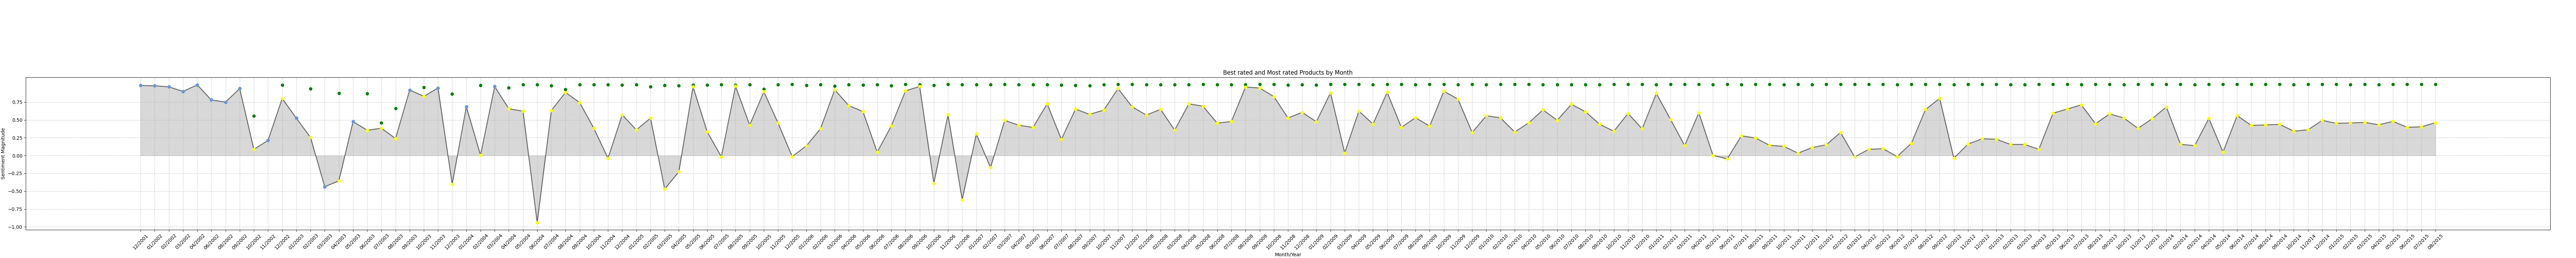

In [3]:
%matplotlib widget
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Here's a sentiment graph of the most and best rated products of each month:\nTOOLTIP: Left click any dot to view info on the product")

df_product_monthly_sentiment = df_dataset.groupBy("product_id", "review_year_month") \
    .agg(
        F.avg("star_rating").alias("avg_rating"),
        F.count("review_id").alias("review_count"),
        F.first("product_title").alias("product_title"),
        F.first("sentiment").alias("val_sentiment"),
        F.avg("magnitude").alias("avg_magnitude")
    )

window_best_rated_sentiment = Window.partitionBy("review_year_month").orderBy(F.desc("avg_magnitude"))
df_best_rated_sentiment = df_product_monthly_sentiment.withColumn("rank", F.row_number().over(window_best_rated_sentiment)).filter(F.col("rank") == 1)

window_most_rated_sentiment = Window.partitionBy("review_year_month").orderBy(F.desc("review_count"))
df_most_rated_sentiment = df_product_monthly_sentiment.withColumn("rank", F.row_number().over(window_most_rated_sentiment)).filter(F.col("rank") == 1)

best_rated_sentiment_data = df_best_rated_sentiment.select("review_year_month", "product_id", "product_title", "review_count", "avg_rating", "val_sentiment", "avg_magnitude").collect()
most_rated_sentiment_data = df_most_rated_sentiment.select("review_year_month", "product_id", "product_title", "review_count", "avg_rating", "val_sentiment", "avg_magnitude").collect()

best_rated_sentiment_data = [
    row for row in best_rated_sentiment_data 
    if row["avg_rating"] is not None and 
       row["review_year_month"] is not None and 
       row["avg_magnitude"] is not None
]

most_rated_sentiment_data = [
    row for row in most_rated_sentiment_data 
    if row["avg_rating"] is not None and 
       row["review_year_month"] is not None and 
       row["avg_magnitude"] is not None
]

best_rated_sentiment_x = []
best_rated_sentiment_y = []
best_rated_sentiment_tooltips = []
for row in best_rated_sentiment_data:
    best_rated_sentiment_x.append(row["review_year_month"])
    best_rated_sentiment_y.append(row["avg_magnitude"])
    best_rated_sentiment_tooltips.append(f"Product ID: {row['product_id']}\nTitle: {row['product_title']}\nReviews: {row['review_count']}\nAvg Rating: {row['avg_rating']}\nSentiment: {row['val_sentiment']}\nSentiment Magnitude: {row['avg_magnitude']}")

most_rated_sentiment_x = []
most_rated_sentiment_y = []
most_rated_sentiment_tooltips = []
for row in most_rated_sentiment_data:
    most_rated_sentiment_x.append(row["review_year_month"])
    most_rated_sentiment_y.append(row["avg_magnitude"])
    most_rated_sentiment_tooltips.append(f"Product ID: {row['product_id']}\nTitle: {row['product_title']}\nReviews: {row['review_count']}\nAvg Rating: {row['avg_rating']}\nSentiment: {row['val_sentiment']}\nSentiment Magnitude: {row['avg_magnitude']}")

best_rated_sentiment_x = pd.to_datetime(best_rated_sentiment_x, errors='coerce')
most_rated_sentiment_x = pd.to_datetime(most_rated_sentiment_x, errors='coerce')
best_rated_sentiment_x = best_rated_sentiment_x.dropna()
most_rated_sentiment_x = most_rated_sentiment_x.dropna()
best_rated_sentiment_x = best_rated_sentiment_x.strftime('%m/%Y')
most_rated_sentiment_x = most_rated_sentiment_x.strftime('%m/%Y')

fig, ax = plt.subplots(figsize=(75, 7.5))
plt.subplots_adjust(left=0.01, right=0.99, top=0.70)

best_rated_sentiment_scatter = ax.scatter(best_rated_sentiment_x, best_rated_sentiment_y, color='green', label='Best rated_sentiment', zorder=3)
most_rated_sentiment_scatter = ax.scatter(most_rated_sentiment_x, most_rated_sentiment_y, color='yellow', label='Most rated_sentiment', zorder=3)

combined_sentiment_x = []
combined_sentiment_y = []
combined_sentiment_tooltips = []
for x, y, tooltip in zip(most_rated_sentiment_x, most_rated_sentiment_y, most_rated_sentiment_tooltips):
    if (x, y) in zip(best_rated_sentiment_x, best_rated_sentiment_y):
        best_index = list(best_rated_sentiment_x).index(x)
        combined_sentiment_x.append(x)
        combined_sentiment_y.append(y)
        combined_sentiment_tooltips.append((best_rated_sentiment_tooltips[best_index], tooltip))

combined_sentiment_scatter = ax.scatter(combined_sentiment_x, combined_sentiment_y, color='cornflowerblue', label='Overlapping', zorder=3)


most_rated_sentiment_x_sorted = np.array(most_rated_sentiment_x)
most_rated_sentiment_y_sorted = np.array(most_rated_sentiment_y)

most_rated_sentiment_df = pd.DataFrame({
    'x': most_rated_sentiment_x_sorted,
    'y': most_rated_sentiment_y_sorted
})

most_rated_sentiment_df['x'] = pd.to_datetime(most_rated_sentiment_df['x'], format='%m/%Y')
most_rated_sentiment_df = most_rated_sentiment_df.sort_values(by='x')

ax.plot(most_rated_sentiment_df['x'].dt.strftime('%m/%Y'), most_rated_sentiment_df['y'], color='black', linestyle='-', linewidth=2, zorder=2, alpha=0.5)
ax.fill_between(most_rated_sentiment_df['x'].dt.strftime('%m/%Y'), most_rated_sentiment_df['y'], color='gray', alpha=0.3, zorder=1)

ax.set_yticks(np.arange(-1, 1, 0.25))
ax.set_xticks(sorted(set(best_rated_sentiment_x.tolist() + most_rated_sentiment_x.tolist())))
ax.set_xticklabels(sorted(set(best_rated_sentiment_x.tolist() + most_rated_sentiment_x.tolist())), rotation=45)
ax.set_xlabel('Month/Year')
ax.set_ylabel('Sentiment Magnitude')
ax.set_title('Best rated and Most rated Products by Month')
ax.grid(True, linestyle='--', alpha=0.75)
ax.legend().set_visible(False)

current_annotation = None

def on_click(event):
    global current_annotation
    if current_annotation is not None:
        current_annotation.remove()
        current_annotation = None
    if event.inaxes == ax:
        for i, point in enumerate(combined_sentiment_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                combined_sentiment_text = f"{combined_sentiment_tooltips[i][0]}\n\n{combined_sentiment_tooltips[i][1]}"
                current_annotation = plt.annotate(combined_sentiment_text, (point[0], point[1] + 0.1), textcoords="offset points", xytext=(0,3), ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='cornflowerblue', facecolor='white', alpha=0.9))
                plt.draw()
                return
        for i, point in enumerate(best_rated_sentiment_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                current_annotation = plt.annotate(best_rated_sentiment_tooltips[i], (point[0], point[1] + 0.1), textcoords="offset points", xytext=(0,3), ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white', alpha=0.9))
                plt.draw()
                return
        for i, point in enumerate(most_rated_sentiment_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                current_annotation = plt.annotate(most_rated_sentiment_tooltips[i], (point[0], point[1] - 0.1), textcoords="offset points", xytext=(0,30), ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='yellow', facecolor='white', alpha=0.9))
                plt.draw()
                return

fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

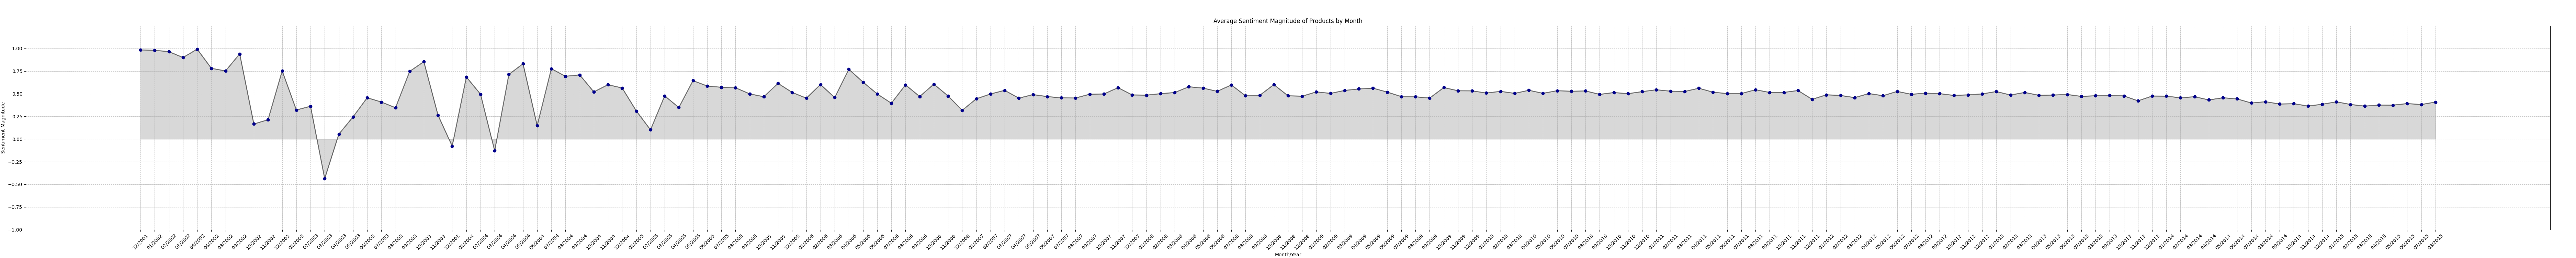

In [4]:
%matplotlib widget
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_monthly_avg_magnitude = df_dataset.groupBy("review_year_month").agg(
    F.avg("magnitude").alias("avg_magnitude"),
    F.count("review_id").alias("review_count"),
    F.collect_list("product_id").alias("product_ids")
)

monthly_avg_magnitude_data = df_monthly_avg_magnitude.select(
    "review_year_month", "avg_magnitude", "review_count", "product_ids"
).collect()

monthly_avg_magnitude_data = [
    row for row in monthly_avg_magnitude_data 
    if row["avg_magnitude"] is not None and row["review_year_month"] is not None
]

avg_magnitude_x = []
avg_magnitude_y = []
avg_magnitude_tooltips = []
for row in monthly_avg_magnitude_data:
    avg_magnitude_x.append(row["review_year_month"])
    avg_magnitude_y.append(row["avg_magnitude"])
    product_ids = row['product_ids']
    formatted_product_ids = '\n'.join([' '.join(product_ids[i:i + 5]) for i in range(0, min(len(product_ids), 10), 5)])
    if len(product_ids) > 10:
        formatted_product_ids = f"{formatted_product_ids}\n and other ids"
    tooltip_text = f"Month: {row['review_year_month']}\nAvg Magnitude: {row['avg_magnitude']}\nReviews: {row['review_count']}\nProduct IDs:\n{formatted_product_ids}"
    avg_magnitude_tooltips.append(tooltip_text)

avg_magnitude_x = pd.to_datetime(avg_magnitude_x, errors='coerce')
avg_magnitude_x = avg_magnitude_x.dropna()
avg_magnitude_x = avg_magnitude_x.strftime('%m/%Y')

fig, ax = plt.subplots(figsize=(75, 7.5))
plt.subplots_adjust(left=0.01, right=0.99, top=0.90)

avg_magnitude_scatter = ax.scatter(avg_magnitude_x, avg_magnitude_y, color='darkblue', label='Average Sentiment Magnitude', zorder=3.5)

ax.set_ylim(-1, 1.25)
ax.set_yticks(np.arange(-1, 1.25, 0.25))

avg_magnitude_df = pd.DataFrame({
    'x': avg_magnitude_x,
    'y': avg_magnitude_y
})
avg_magnitude_df['x'] = pd.to_datetime(avg_magnitude_df['x'], format='%m/%Y')
avg_magnitude_df = avg_magnitude_df.sort_values(by='x')

ax.plot(avg_magnitude_df['x'].dt.strftime('%m/%Y'), avg_magnitude_df['y'], color='black', linestyle='-', linewidth=2, zorder=2, alpha=0.5)
ax.fill_between(avg_magnitude_df['x'].dt.strftime('%m/%Y'), avg_magnitude_df['y'], color='gray', alpha=0.3, zorder=1)

ax.set_xticks(sorted(set(avg_magnitude_x.tolist())))
ax.set_xticklabels(sorted(set(avg_magnitude_x.tolist())), rotation=45)
ax.set_xlabel('Month/Year')
ax.set_ylabel('Sentiment Magnitude')
ax.set_title('Average Sentiment Magnitude of Products by Month')
ax.grid(True, linestyle='--', alpha=0.75)
ax.legend().set_visible(False)

current_annotation = None

def on_click(event):
    global current_annotation
    if current_annotation is not None:
        current_annotation.remove()
        current_annotation = None
    if event.inaxes == ax:
        for i, point in enumerate(avg_magnitude_scatter.get_offsets()):
            if np.isclose(point[0], event.xdata, atol=0.1) and np.isclose(point[1], event.ydata, atol=0.1):
                current_annotation = plt.annotate(
                    avg_magnitude_tooltips[i], 
                    (point[0], point[1] + 0.1), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', 
                    fontsize=10, 
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkblue', facecolor='white', alpha=0.9)
                )
                plt.draw()
                return

fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


Combobox(value='', description='Select Product:', layout=Layout(margin='0 0 0 20px'), options=('85 [B002ABX29I…

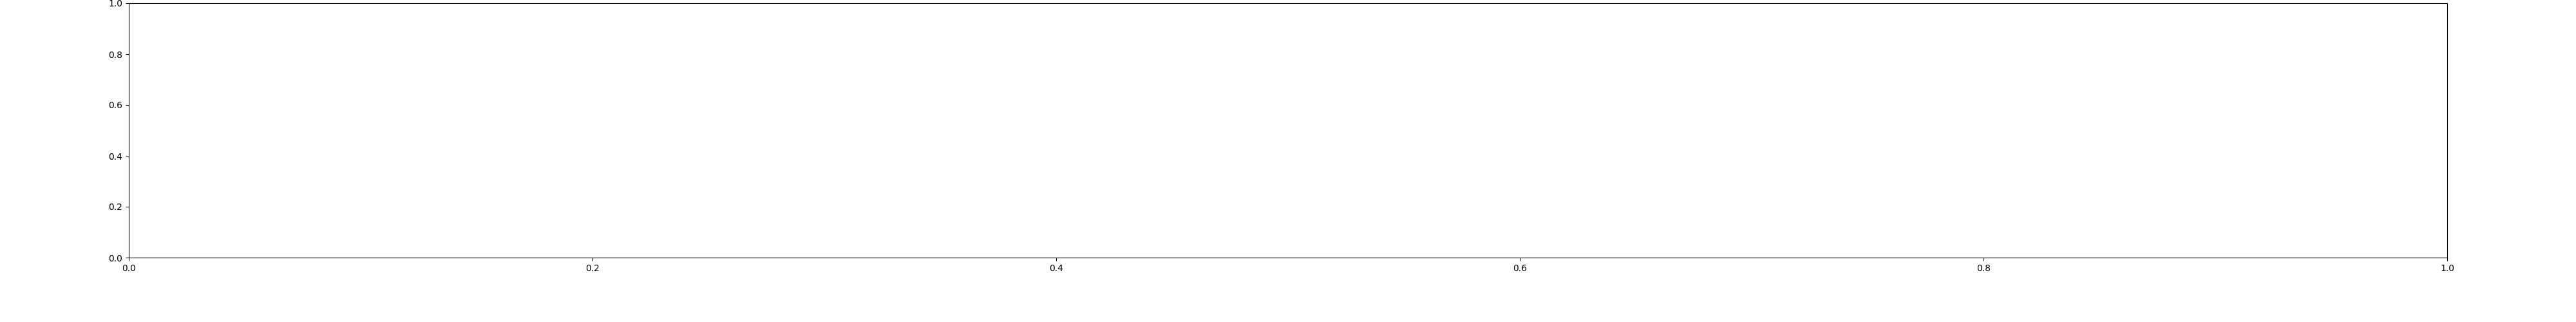

In [5]:
%matplotlib widget
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets

def preprocess_data():
    global df_dataset

    df_monthly_avg_magnitude = df_dataset.groupBy("review_year_month", "product_id", "product_title").agg(
        F.avg("magnitude").alias("avg_magnitude"),
        F.count("review_id").alias("review_count")
    )

    monthly_avg_magnitude_data = df_monthly_avg_magnitude.select(
        "review_year_month", "product_id", "product_title", "avg_magnitude", "review_count"
    ).collect()

    return [
        row for row in monthly_avg_magnitude_data 
        if row["avg_magnitude"] is not None and row["review_year_month"] is not None
    ]

monthly_avg_magnitude_data = preprocess_data()

product_options = {
    f"{row['review_count']} [{row['product_id']}] {row['product_title'][:32] + '...' if len(row['product_title']) > 32 else row['product_title']}": row['product_id']
    for row in df_dataset.select("product_id", "product_title", "review_id").groupBy("product_id", "product_title").agg(F.count("review_id").alias("review_count")).distinct().collect()
}

def plot_avg_magnitude_for_product(selected_product_id):
    ax.clear()

    filtered_data = [row for row in monthly_avg_magnitude_data if row['product_id'] == selected_product_id]
    
    avg_magnitude_x = []
    avg_magnitude_y = []
    
    for row in filtered_data:
        avg_magnitude_x.append(row["review_year_month"])
        avg_magnitude_y.append(row["avg_magnitude"])

    avg_magnitude_x = pd.to_datetime(avg_magnitude_x, errors='coerce')
    avg_magnitude_y = np.array(avg_magnitude_y)

    avg_magnitude_df = pd.DataFrame({
        'review_year_month': avg_magnitude_x,
        'avg_magnitude': avg_magnitude_y
    })
    
    avg_magnitude_df = avg_magnitude_df.dropna().sort_values(by='review_year_month')

    ax.scatter(avg_magnitude_df['review_year_month'], avg_magnitude_df['avg_magnitude'], color='darkblue', label='Average Sentiment Magnitude', zorder=3.5)

    ax.set_ylim(-1, 1.25)
    ax.set_yticks(np.arange(-1, 1.25, 0.25))

    ax.plot(avg_magnitude_df['review_year_month'], avg_magnitude_df['avg_magnitude'], color='black', linestyle='-', linewidth=2, zorder=2, alpha=0.5)
    ax.fill_between(avg_magnitude_df['review_year_month'], avg_magnitude_df['avg_magnitude'], color='gray', alpha=0.3, zorder=1)

    ax.set_xticks(avg_magnitude_df['review_year_month'])
    ax.set_xticklabels(avg_magnitude_df['review_year_month'].dt.strftime('%m/%Y'), rotation=45)
    ax.set_xlabel('Month/Year')
    ax.set_ylabel('Sentiment Magnitude')
    ax.set_title(f'Average Sentiment Magnitude for Product ID: {selected_product_id} by Month')
    ax.grid(True, linestyle='--', alpha=0.75)
    ax.legend().set_visible(False)

    plt.draw()

fig, ax = plt.subplots(figsize=(40, 5))
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, bottom=0.2)

# Create a combobox for product selection using ipywidgets with adjusted layout
product_combobox = widgets.Combobox(
    options=list(product_options.keys()),
    description='Select Product:',
    disabled=False,
    layout=widgets.Layout(margin='0 0 0 20px')  # Adjust the left margin to move it to the right
)

def on_product_selected(change):
    selected_product_id = product_options[change['new']]
    plot_avg_magnitude_for_product(selected_product_id)

product_combobox.observe(on_product_selected, names='value')

display(product_combobox)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

print("Basic Statistics:")
df_with_sentiment.describe(['magnitude']).show()


sentiment_counts = df_with_sentiment.groupBy('sentiment').count().orderBy('count', ascending=False)
print("\nSentiment Distribution:")
sentiment_counts.show()

avg_magnitude = df_with_sentiment.groupBy('sentiment').agg(F.avg('magnitude').alias('avg_magnitude'), F.stddev('magnitude').alias('std_magnitude'))
print("\nMagnitude Statistics by Sentiment:")
avg_magnitude.show()


print("\nSentiment Over Time:")
sentiment_over_time = df_dataset.groupBy('review_year_month', 'sentiment').count().orderBy('review_year_month').show()

print("\nAverage Rating by Sentiment:")
df_dataset.groupBy('sentiment').agg(F.avg('star_rating').alias('avg_rating'), F.count('*').alias('count')).orderBy('avg_rating', ascending=False).show()

print("\nSentiment Distribution by Verified Purchase:")
df_dataset.groupBy('verified_purchase', 'sentiment').count().orderBy('verified_purchase', 'sentiment').show()


def plot_enhanced_sentiment_analysis(df_with_sentiment, df_dataset):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(231)
    sentiment_counts_pd = df_with_sentiment.groupBy('sentiment').count().toPandas()
    plt.pie(sentiment_counts_pd['count'], labels=sentiment_counts_pd['sentiment'],  autopct='%1.1f%%', colors=['#2ecc71', '#95a5a6', '#e74c3c'])
    plt.title('Sentiment Distribution')
    
    plt.subplot(232)
    magnitude_pd = df_with_sentiment.select('magnitude', 'sentiment').toPandas()
    sns.histplot(data=magnitude_pd, x='magnitude', hue='sentiment', bins=30)
    plt.title('Magnitude Distribution by Sentiment')
    
    plt.subplot(233)
    sns.boxplot(data=magnitude_pd, x='sentiment', y='magnitude', palette=['#2ecc71', '#95a5a6', '#e74c3c'])
    plt.title('Magnitude Box Plot by Sentiment')
    
    plt.subplot(234)
    rating_pd = df_dataset.select('star_rating', 'sentiment').toPandas()
    sns.boxplot(data=rating_pd, x='sentiment', y='star_rating', palette=['#2ecc71', '#95a5a6', '#e74c3c'])
    plt.title('Star Rating by Sentiment')
    
    plt.tight_layout()
    plt.show()


def plot_temporal_patterns(df_dataset):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(221)
    monthly_sentiment = df_dataset.groupBy('review_year_month', 'sentiment').count().toPandas()
    sentiment_pivot = monthly_sentiment.pivot(index='review_year_month', columns='sentiment', values='count')
    sentiment_pivot.plot(marker='o')
    plt.title('Monthly Sentiment Trends')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def run_complete_analysis(df_with_sentiment, df_dataset):
    plot_enhanced_sentiment_analysis(df_with_sentiment, df_dataset)
    plot_temporal_patterns(df_dataset)

run_complete_analysis(df_with_sentiment, df_dataset)